<a href="https://colab.research.google.com/github/shemaaali/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/LS_DS_213_assignment/SDA3_LS_DS18_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [471]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [472]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

## Wrangle Data

In [473]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


dtype_dict = {'ZIP_CODE': 'object',
              'YEAR_BUILT': int}

df = pd.read_csv(DATA_PATH+'condos/tribeca.csv', 
                 dtype=dtype_dict, 
                 parse_dates=['SALE_DATE'],
                 index_col='SALE_DATE')
print(df.shape)
df.head()

(90, 8)


,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,GROSS_SQUARE_FEET,YEAR_BUILT,SALE_PRICE
SALE_DATE,,,,,,,,
2019-01-03,TRIBECA,13 CONDOS - ELEVATOR APARTMENTS,"181 HUDSON STREET, 6D",6D,10013.0,"1,840",1909,2800000
2019-01-07,TRIBECA,13 CONDOS - ELEVATOR APARTMENTS,"10 LITTLE WEST STREET, 19A",19A,10004.0,"1,759",0,2650000
2019-01-09,TRIBECA,13 CONDOS - ELEVATOR APARTMENTS,"30 LITTLE WEST STREET, 7G",7G,10004.0,"1,190",2005,1005000
2019-01-10,TRIBECA,13 CONDOS - ELEVATOR APARTMENTS,"2 RIVER TERRACE, 4C",4C,0.0,"1,088",2006,1678000
2019-01-11,TRIBECA,13 CONDOS - ELEVATOR APARTMENTS,"380 RECTOR PLACE, 10A",10A,10280.0,873,0,1380000


In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90 entries, 2019-01-03 to 2019-04-30
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   NEIGHBORHOOD             90 non-null     object 
 1   BUILDING_CLASS_CATEGORY  90 non-null     object 
 2   ADDRESS                  90 non-null     object 
 3   APARTMENT_NUMBER         90 non-null     object 
 4   ZIP_CODE                 90 non-null     object 
 5   GROSS_SQUARE_FEET        90 non-null     float64
 6   YEAR_BUILT               90 non-null     int64  
 7   SALE_PRICE               90 non-null     int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 6.3+ KB


In [182]:
df.describe()

,GROSS_SQUARE_FEET,YEAR_BUILT,SALE_PRICE
count,90,90,90
mean,"1,766","1,585","3,928,736"
std,"1,019",798,"3,621,996"
min,432,0,"424,770"
25%,874,"1,905","1,156,552"
50%,"1,626","1,987","2,750,000"
75%,"2,308","2,006","5,087,500"
max,"4,986","2,016","15,000,000"


## EDA

In [183]:
pd.options.display.float_format = '{:,.0f}'.format

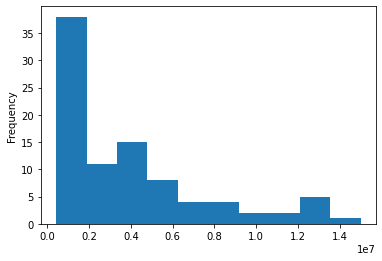

In [474]:
df['SALE_PRICE'].plot(kind='hist')

In [95]:
df.describe()['SALE_PRICE']

count           90
mean     3,928,736
std      3,621,996
min        424,770
25%      1,156,552
50%      2,750,000
75%      5,087,500
max     15,000,000
Name: SALE_PRICE, dtype: float64

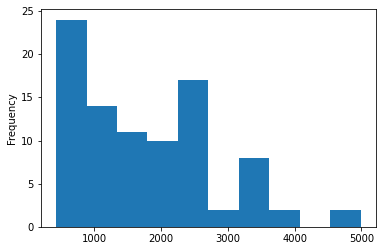

In [475]:
df['GROSS_SQUARE_FEET'].plot(kind='hist')

In [97]:
df.select_dtypes('object').head()

,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,ADDRESS,APARTMENT_NUMBER,ZIP_CODE
SALE_DATE,,,,,
2019-01-03,TRIBECA,13 CONDOS - ELEVATOR APARTMENTS,"181 HUDSON STREET, 6D",6D,10013.0
2019-01-07,TRIBECA,13 CONDOS - ELEVATOR APARTMENTS,"10 LITTLE WEST STREET, 19A",19A,10004.0
2019-01-09,TRIBECA,13 CONDOS - ELEVATOR APARTMENTS,"30 LITTLE WEST STREET, 7G",7G,10004.0
2019-01-10,TRIBECA,13 CONDOS - ELEVATOR APARTMENTS,"2 RIVER TERRACE, 4C",4C,0.0
2019-01-11,TRIBECA,13 CONDOS - ELEVATOR APARTMENTS,"380 RECTOR PLACE, 10A",10A,10280.0


In [114]:
df['BUILDING_CLASS_CATEGORY'].value_counts()

13 CONDOS - ELEVATOR APARTMENTS    90
Name: BUILDING_CLASS_CATEGORY, dtype: int64

In [ ]:
# Filtering
feature_subset = df[df['BUILDING_CLASS_CATEGORY']=='01 ONE FAMILY DWELLINGS']
target_subset = df[(df['SALE_PRICE'] >= 100000) & (df['SALE_PRICE'] <= 2000000)]

## Split Data

In [385]:
# Split data
# Drope anything I do not want
y = df.SALE_PRICE
X = df.drop(['SALE_PRICE', 'ADDRESS', 'NEIGHBORHOOD', 'ZIP_CODE'], axis=1)

In [388]:
# Use data from Jan-March 2019 to train
# Use data from April 2019 to test
cutoff = '2019-04-01'
mask = X.index < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_val, y_val = X.loc[~mask], y.loc[~mask]

In [389]:
X_train.shape

(65, 4)

In [480]:
df.shape

(90, 8)

In [391]:
y_train.shape

(65,)

In [392]:
len(y_train)

65

In [393]:
# Check if that true
X_train.shape[0] + X_val.shape[0] == X.shape[0]

True

## Establish Baseline

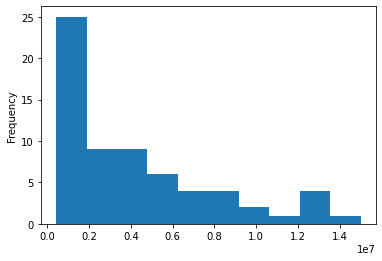

In [479]:
y_train.plot(kind='hist');

In [394]:
from sklearn.metrics import mean_absolute_error

print('Baseline MAE:', mean_absolute_error(y_train, [y_train.mean()]*len(y_train)))

Baseline MAE: 2974677.6923076925


## Build Model

## Transformer #1: One hot encoding

In [405]:
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression
import category_encoders as ce

In [406]:
# Instantiate Transformer
one_hot_encod = ce.OneHotEncoder(use_cat_names=True)

In [407]:
# Transform Feature Matrix for both training and testing
XT_train = one_hot_encod.fit_transform(X_train)

In [411]:
# Instantiate Predictor
model_linear_reg = Ridge()

In [412]:
# Fit on the TRANSFORMED data
model_linear_reg.fit(XT_train, y_train);

In [413]:
y_pred_train = model_linear_reg.predict(XT_train)

In [415]:
# This can't retrain the transformer
XT_val = one_hot_encod.transform(X_val)
y_pred_val = model_linear_reg.predict(XT_val)

In [416]:
print('Training MAE:', mean_absolute_error(y_train, y_pred_train))
print('Validation MAE:', mean_absolute_error(y_val, y_pred_val))

Training MAE: 627066.963636839
Validation MAE: 1084735.5197137983


In [417]:
# Check my score
model_linear_reg.score(XT_val, y_val)

0.729023253150876

## Transformer #2: SelectKBest

In [418]:
# Want see how many columns do I have before the second transformer?
len(X_train.columns)

4

In [ ]:
from sklearn.feature_selection import SelectKBest

k_values = list(range(1,len(X_train.columns)+1))
r2_scores = []

for k in k_values:
  # Instantiate Transformer 1
  one_hot_encod = ce.OneHotEncoder(use_cat_names=True)

  # Fit_transform 1
  XT_train = one_hot_encod.fit_transform(X_train)

  # Instantiate Transformer 2
  skb = SelectKBest(k=k)

  # Fit_transform 2
  XTT_train = skb.fit_transform(XT_train, y_train)

  # Instantiate Predictor
  model_linear_reg = LinearRegression()

  # Fit on the DOUBLE-TRANSFORMED data
  model_linear_reg.fit(XTT_train, y_train)

  # Get R^2 score
  r2_scores.append(model_linear_reg.score(XTT_train, y_train))

Text(0, 0.5, '$R^2$ score')

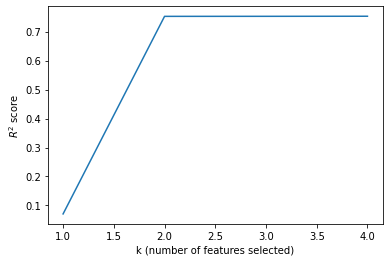

In [478]:
import matplotlib.pyplot as plt
plt.plot(k_values, r2_scores)
plt.xlabel('k (number of features selected)')
plt.ylabel('$R^2$ score')

## Predictor: Ridge

In [428]:
from sklearn.linear_model import Ridge

In [430]:
model_ridge = Ridge()
model_ridge.fit(XT_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [431]:
model_ridge.score(XT_val, y_val)

0.729023253150876

## Stretch Goals

In [467]:
# RidgeCV
from sklearn.linear_model import RidgeCV

alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
ridge = RidgeCV(alphas=alphas, normalize=True)
ridge.fit(anscombe[['x']], anscombe['y'])
ridge.alpha_

0.1

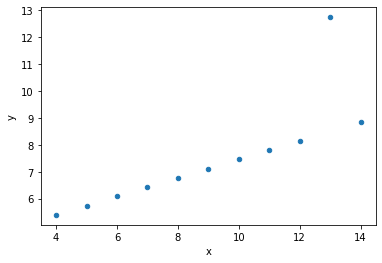

In [463]:
# OLS vs Mean Baseline vs Ridge for anscombe and III data
import seaborn as sns
anscombe = sns.load_dataset('anscombe').query('dataset=="III"')
anscombe.plot.scatter('x', 'y')
plt.show()

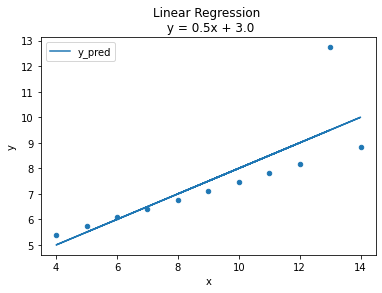

In [462]:
# OLS
%matplotlib inline

# Plot data
ax = anscombe.plot.scatter('x', 'y')

# Fit linear model
ols = LinearRegression()
ols.fit(anscombe[['x']], anscombe['y'])

# Get linear equation
m = ols.coef_[0].round(2)
b = ols.intercept_.round(2)
title = f'Linear Regression \n y = {m}x + {b}'

# Get predictions
anscombe['y_pred'] = ols.predict(anscombe[['x']])

# Plot predictions
anscombe.plot('x', 'y_pred', ax=ax, title=title);

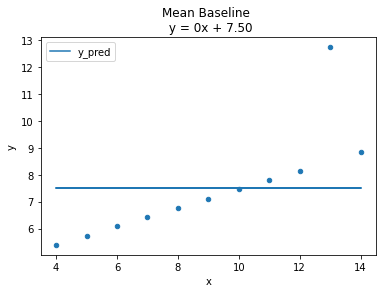

In [464]:
# Mean Baseline
ax = anscombe.plot.scatter('x', 'y')

# Mean baseline
mean = anscombe['y'].mean()
anscombe['y_pred'] = mean
title = f'Mean Baseline \n y = 0x + {mean:.2f}'

# Plot "predictions"
anscombe.plot('x', 'y_pred', ax=ax, title=title);

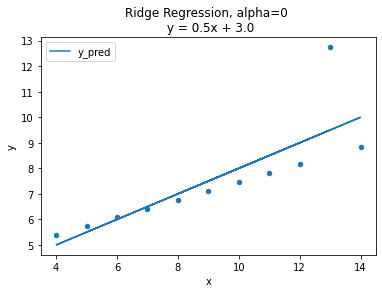

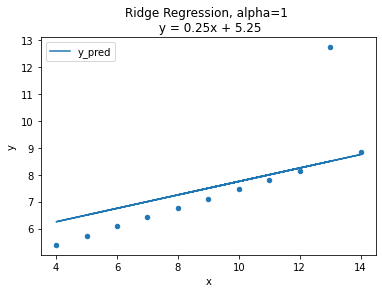

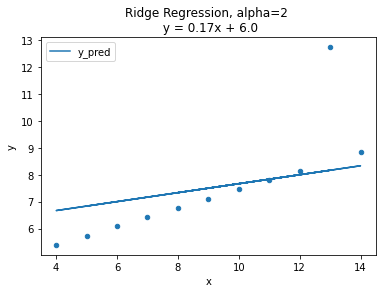

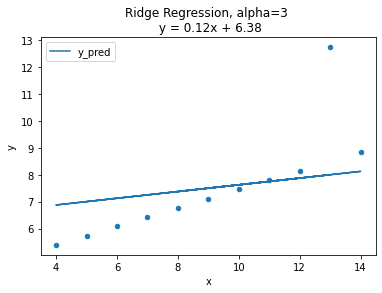

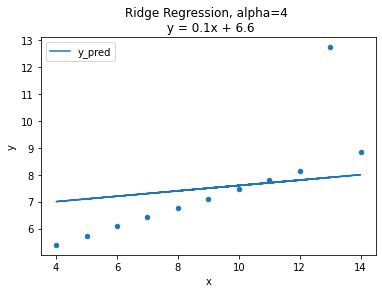

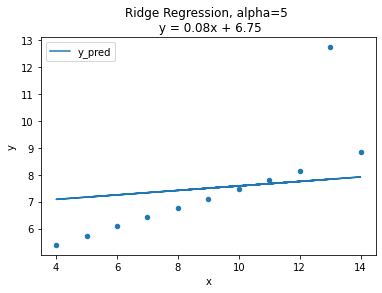

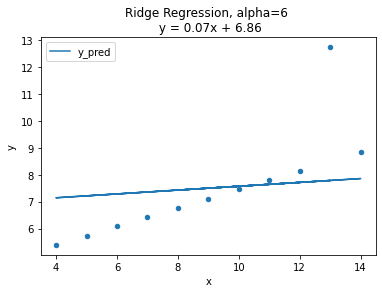

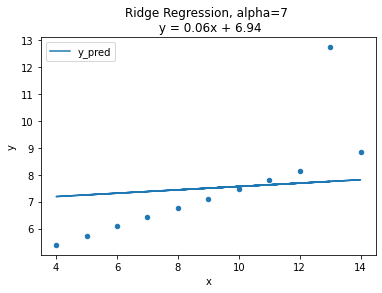

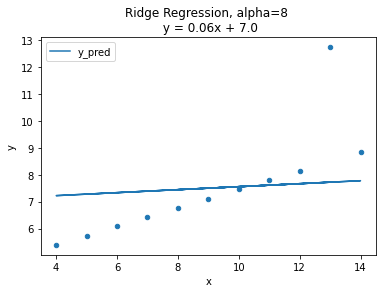

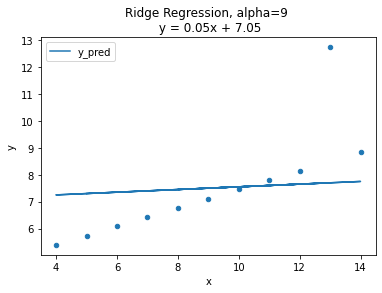

In [465]:
# Ridge Regression with increasing regularization:
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

def ridge_anscombe(alpha):
    """
    Fit & plot a ridge regression model,
    with Anscombe Quartet dataset III.

    alpha : positive float, regularization strength
    """

    # Load data
    anscombe = sns.load_dataset('anscombe').query('dataset=="III"')

    # Plot data
    ax = anscombe.plot.scatter('x', 'y')

    # Fit linear model
    ridge = Ridge(alpha=alpha, normalize=True)
    ridge.fit(anscombe[['x']], anscombe['y'])

    # Get linear equation
    m = ridge.coef_[0].round(2)
    b = ridge.intercept_.round(2)
    title = f'Ridge Regression, alpha={alpha} \n y = {m}x + {b}'

    # Get predictions
    anscombe['y_pred'] = ridge.predict(anscombe[['x']])

    # Plot predictions
    anscombe.plot('x', 'y_pred', ax=ax, title=title)
    plt.show()
    
    
for alpha in range(10):
    ridge_anscombe(alpha=alpha)